In [96]:
import Pkg
Pkg.activate("../../../.")
using Plots
using JLD2
using Random, Distributions
using StatsBase
using Plots.PlotMeasures
include("../../../LogLoss/RealRealHighDimension.jl")
include("../../../Interpolation/ForecastingMainNew.jl");
include("complex_dataset_generation.jl");

  Activating project at `~/Desktop/QuantumInspiredML`


# Dataset 1 - Fixed Period, 2 Trends

Tau = 20, m = -3, 3

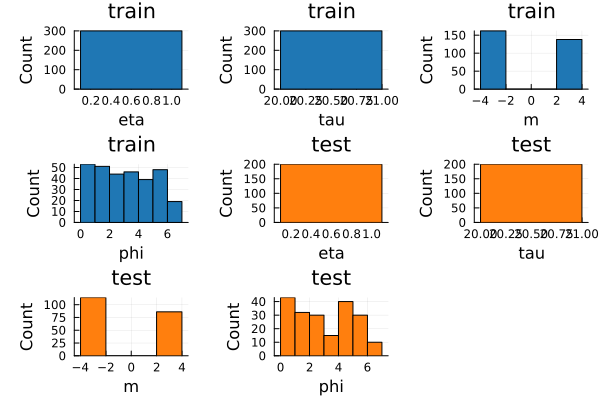

(([0.6181191875587932 0.4445504348091971 … -1.9237600185067398 -2.27326573762465; -0.10195450110522503 0.19158252071922421 … -3.58932197890419 -3.2993610655520675; … ; -0.684656496582238 -0.770167255632707 … 1.9148768881694296 2.0599960864299383; -0.10064641162567332 -0.32275406387193006 … -2.2567161092661867 -2.5359302433709168], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), ([0.5932265354984184 0.35034527047309993 … -1.8239151631197148 -1.9085541373889452; -1.0200595252646074 -0.9310553093445805 … -3.540181847555788 -3.766968557153738; … ; 0.23206909299598713 0.5540978863690748 … -3.0523927233125794 -3.071917787895533; 0.5461799080263195 0.01019124971345356 … 3.638692695980759 3.7587324404940192], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (Dict[Dict{Symbol, Real}(:T => 100, :m => -3, :eta => 0.1, :phi => 2.54908495463933, :tau => 20.0), Dict{Symbol, Real}(:T => 100, :m => -3, :eta => 0.1, :phi => 6.165933776252436, :tau => 20.0), Dict{Symbo

In [80]:
T = 100
ntrain = 300
ntest = 200
eta = 0.1
m = [-3, 3] # continuous uniform dist
phi = (0, 2π) # continuous uniform dist
tau = 20.0
state = 0
save=true
(X_train, y_train), (X_test, y_test), (train_metadata, test_metadata) = construct_dataset(T, ntrain, ntest, eta, m, phi, tau; state=state, save=save)

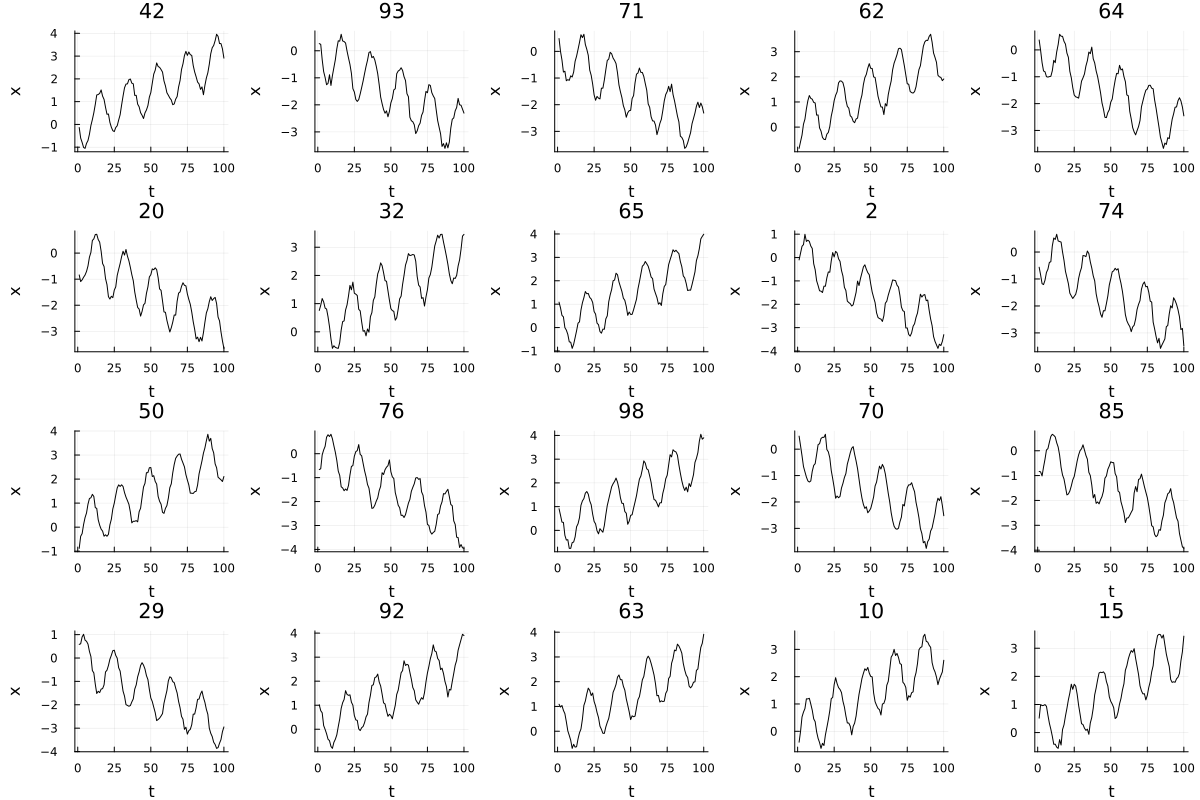

In [60]:
plot_idxs = sample(1:size(X_train,1), 20; replace=false);
ps = []
for pidx in plot_idxs
    p = plot(X_train[pidx, :], label ="", c=:black, title=pidx, xlabel="t", ylabel="x")
    push!(ps, p)
end
plot(ps..., size=(1200, 800), left_margin=5mm)

In [81]:
svpath_ns = "../../../Data/syntheticV2/complex/mps_saves/d1_legendre_ns_d20_chi100.jld2";
dloc =  "../../../Data/syntheticV2/complex/datasets/eta_0.1_m_disc_range_2_phi_cont_range_0_6.283185307179586_tau_20.0.jld2";

In [82]:
f = jldopen(dloc, "r")
    X_train = read(f, "X_train")
    y_train = read(f, "y_train")
    X_test = read(f, "X_test")
    y_test = read(f, "y_test")
close(f)

In [83]:
f = jldopen(svpath_ns, "r")
    mps_ns = read(f, "mps")
    opts_ns = read(f, "opts")
close(f)
opts_ns, _... = safe_options(opts_ns, nothing, nothing)

fc_ns_d1 = load_forecasting_info_variables(mps_ns, X_train, y_train, X_test, y_test, opts_ns);

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 300 training samples and 200 testing samples.
 - 1 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 100

 Created 1 forecastable struct(s) containing class-wise mps and test samples.


╭────────┬──────────╮
│ Metric │    Value │
├────────┼──────────┤
│    MAE │ 0.117522 │
│ NN_MAE │  0.11302 │
╰────────┴──────────╯


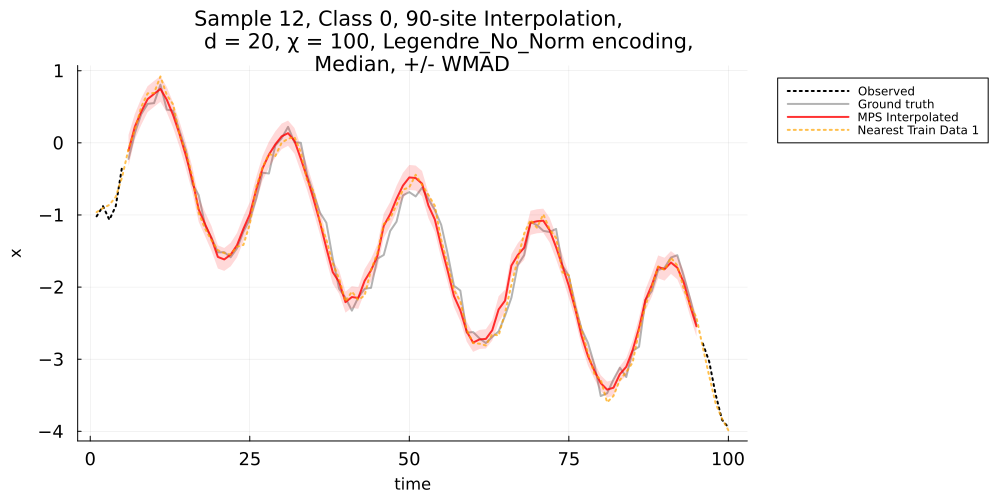

In [138]:
interp_sites = collect(6:95)
class = 0
stats, p1_ns = any_interpolate_median(fc_ns_d1, class, 12, interp_sites; NN_baseline=true, 
    X_train=X_train, y_train=y_train, n_baselines=1, plot_fits=true, wmad=true)
pretty_table(stats; header=["Metric", "Value"], header_crayon= crayon"yellow bold", tf = tf_unicode_rounded);
plot(p1_ns..., xtickfont=font(12), ytickfont=font(12))

In [152]:
function evaluate_windows(forecastable::Vector{forecastable}, X_train::Matrix, y_train::Vector)
    windows = [(i, j) for (i, j) in zip(6:2:95, 95:-2:6) if j >= i]
    nn_per_window_scores = Vector{Vector}(undef, length(windows))
    mps_per_window_scores = Vector{Vector}(undef, length(windows))

    for (iw, w) in enumerate(windows)
        println("Evaluating window: $w")
        lower, upper = w
        num_samps = size(X_test, 1)
        nn_maes = Vector{Float64}(undef, num_samps)
        mps_maes = Vector{Float64}(undef, num_samps)
        interp_sites = collect(lower:upper)
        for i=1:num_samps
            stats, p1_ns = any_interpolate_median(forecastable, 0, i, interp_sites; NN_baseline=true, 
                X_train=X_train, y_train=y_train, n_baselines=1, plot_fits=false)
            nn_maes[i] = stats[:NN_MAE]
            mps_maes[i] = stats[:MAE]
        end

        nn_per_window_scores[iw] = nn_maes
        mps_per_window_scores[iw] = mps_maes 
        println("Window: $w | MPS mean: $(mean(mps_maes)) MPS std: $(std(mps_maes)) | 1NN mean: $(mean(nn_maes)) | 1NN std: $(std(nn_maes))")
    end

    return windows, nn_per_window_scores, mps_per_window_scores
end

evaluate_windows (generic function with 1 method)

In [ ]:
windows, nn_per_window_scores, mps_per_window_scores = evaluate_windows(fc_ns_d1, X_train, y_train)

Evaluating window: (6, 95)
Window: (6, 95) | MPS mean: 0.10405930644489648 MPS std: 0.02030124704760624 | 1NN mean: 0.12408675437657482 | 1NN std: 0.01695710933896303
Evaluating window: (8, 93)
Window: (8, 93) | MPS mean: 0.10218912281287207 MPS std: 0.01782343023316623 | 1NN mean: 0.12239517315951924 | 1NN std: 0.014382706854885834
Evaluating window: (10, 91)
Window: (10, 91) | MPS mean: 0.10099369380131838 MPS std: 0.016155431929638853 | 1NN mean: 0.11951226785711462 | 1NN std: 0.012026206601358544
Evaluating window: (12, 89)
Window: (12, 89) | MPS mean: 0.09951810113315256 MPS std: 0.015328464138207407 | 1NN mean: 0.11965839237516179 | 1NN std: 0.012034481934615496
Evaluating window: (14, 87)


In [79]:
windows = [(i, j) for (i, j) in zip(6:2:95, 95:-2:6) if j >= i];
nn_mean_mae_per_window_d1 = Vector{Float64}(undef, length(windows))
nn_std_mae_per_window_d1 = Vector{Float64}(undef, length(windows))
mps_mean_mae_per_window_d1 = Vector{Float64}(undef, length(windows))
mps_std_mae_per_window_d1 = Vector{Float64}(undef, length(windows))
for (iw, w) in enumerate(windows)
    println("Evaluating window: $w")
    lower, upper = w
    num_samps = size(X_test, 1)
    nn_maes = Vector{Float64}(undef, num_samps)
    mps_maes = Vector{Float64}(undef, num_samps)
    interp_sites = collect(lower:upper)
    for i=1:num_samps
        stats, p1_ns = any_interpolate_median(fc_ns_d1, 0, i, interp_sites; NN_baseline=true, 
            X_train=X_train, y_train=y_train, n_baselines=1, plot_fits=false)
        nn_maes[i] = stats[:NN_MAE]
        mps_maes[i] = stats[:MAE]
    end
    # take the mean and std
    mps_mean, mps_std = mean(mps_maes), std(mps_maes)
    nn_mean, nn_std = mean(nn_maes), std(nn_maes)

    nn_mean_mae_per_window_d1[iw] = nn_mean
    nn_std_mae_per_window_d1[iw] = nn_std
    mps_mean_mae_per_window_d1[iw] = mps_mean
    mps_std_mae_per_window_d1[iw] = mps_std

    # print stats
    println("Window: $w | MPS mean: $mps_mean MPS std: $mps_std | 1NN mean: $nn_mean | 1NN std: $nn_std")
end

Evaluating window: (6, 95)
Window: (6, 95) | MPS mean: 0.10641157780988207 MPS std: 0.023470843271308474 | 1NN mean: 0.1251675032660689 | 1NN std: 0.01907966260972842
Evaluating window: (8, 93)
Window: (8, 93) | MPS mean: 0.10384853640912585 MPS std: 0.020316160326996433 | 1NN mean: 0.12208341477641654 | 1NN std: 0.015725191285064617
Evaluating window: (10, 91)
Window: (10, 91) | MPS mean: 0.10183641408660524 MPS std: 0.01637602311845935 | 1NN mean: 0.12068433413951497 | 1NN std: 0.013865051552638846
Evaluating window: (12, 89)
Window: (12, 89) | MPS mean: 0.10164954858094545 MPS std: 0.016342682526904097 | 1NN mean: 0.12080491019551368 | 1NN std: 0.014888450320425723
Evaluating window: (14, 87)
Window: (14, 87) | MPS mean: 0.1015460824060585 MPS std: 0.016589757435525293 | 1NN mean: 0.11918813365548822 | 1NN std: 0.01447361918620382
Evaluating window: (16, 85)
Window: (16, 85) | MPS mean: 0.10198746700981572 MPS std: 0.01752622868994746 | 1NN mean: 0.11904088202960737 | 1NN std: 0.014

In [80]:
window_sizes = [length(collect(first(windows[i]):last(windows[i]))) for i in 1:23]
cpal = palette(:tab10)

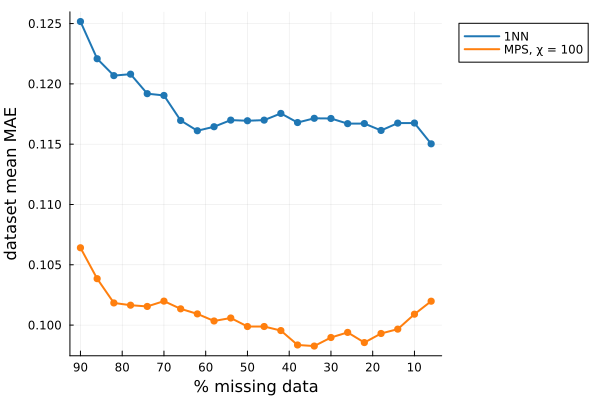

In [128]:
plot(window_sizes[1:end-1], nn_mean_mae_per_window_d1[1:end-1], label="1NN", 
    legend=:outertopright, xlabel="% missing data", ylabel="dataset mean MAE", xticks=collect(90:-10:2),
    c=cpal[1], lw=2)
scatter!(window_sizes[1:end-1], nn_mean_mae_per_window_d1[1:end-1], c=cpal[1], markerstrokewidth=0, label="")
plot!(window_sizes[1:end-1], mps_mean_mae_per_window_d1[1:end-1], label="MPS, χ = 100", c=cpal[2], lw=2)
scatter!(window_sizes[1:end-1], mps_mean_mae_per_window_d1[1:end-1], c=cpal[2], markerstrokewidth=0, label="")
xflip!(true)

What is causing this small spike at around 10-20 percent missing data? I think the 1NN getting slightly better would make sense, given that we have more points with which to compare to the training set, finding a closer match (as long as curse of dimensionality doesn't prevent this). Perhaps the MAE is more sensitive to fluctuations since there are less overall points and so any deviations carry more weight (not flushed out).

In [95]:
# @save "dataset1_d20_chi_100.jld2" nn_mean_mae_per_window_d1 nn_std_mae_per_window_d1 mps_mean_mae_per_window_d1 mps_std_mae_per_window_d1

In [129]:
windows[end-2]

(46, 55)

Plot some examples:

╭────────┬───────────╮
│ Metric │     Value │
├────────┼───────────┤
│    MAE │ 0.0883973 │
│ NN_MAE │  0.115106 │
╰────────┴───────────╯


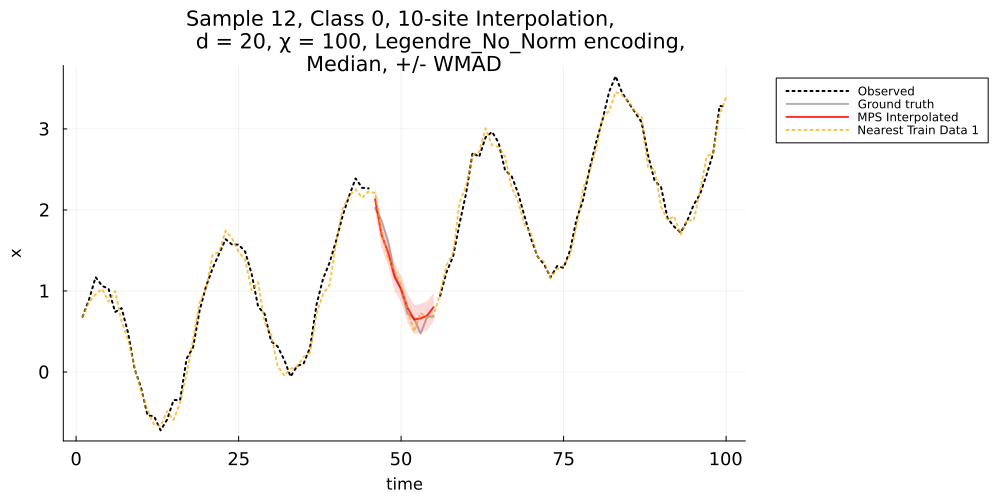

In [144]:
interp_sites = collect(46:55)
class = 0
stats, p1_ns = any_interpolate_median(fc_ns_d1, class, 12, interp_sites; NN_baseline=true, 
    X_train=X_train, y_train=y_train, n_baselines=1, plot_fits=true, wmad=true)
pretty_table(stats; header=["Metric", "Value"], header_crayon= crayon"yellow bold", tf = tf_unicode_rounded);
plot(p1_ns..., xtickfont=font(12), ytickfont=font(12))

╭────────┬──────────╮
│ Metric │    Value │
├────────┼──────────┤
│    MAE │ 0.122712 │
│ NN_MAE │ 0.108678 │
╰────────┴──────────╯


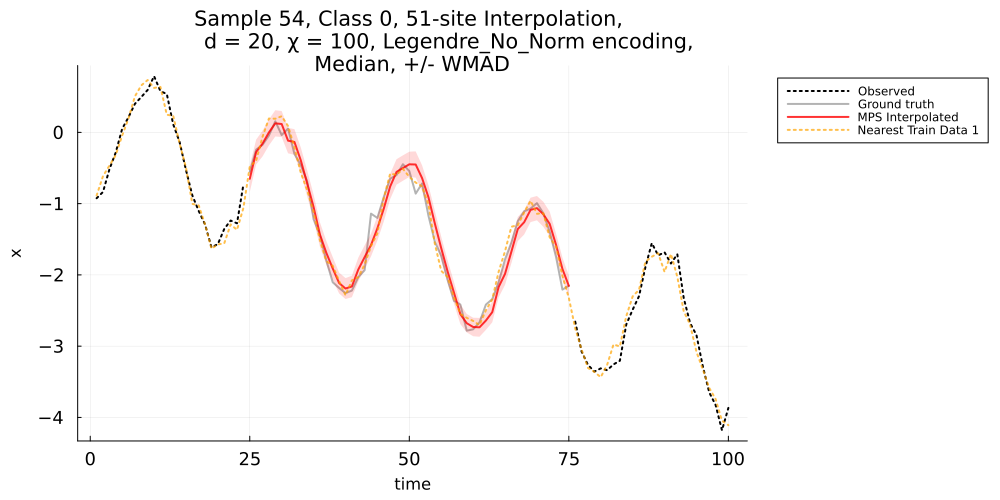

In [132]:
interp_sites = collect(25:75)
class = 0
stats, p1_ns = any_interpolate_median(fc_ns_d1, class, rand(1:size(X_test, 1)), interp_sites; NN_baseline=true, 
    X_train=X_train, y_train=y_train, n_baselines=1, plot_fits=true, wmad=true)
pretty_table(stats; header=["Metric", "Value"], header_crayon= crayon"yellow bold", tf = tf_unicode_rounded);
plot(p1_ns..., xtickfont=font(12), ytickfont=font(12))

╭────────┬───────────╮
│ Metric │     Value │
├────────┼───────────┤
│    MAE │ 0.0872578 │
│ NN_MAE │  0.114774 │
╰────────┴───────────╯


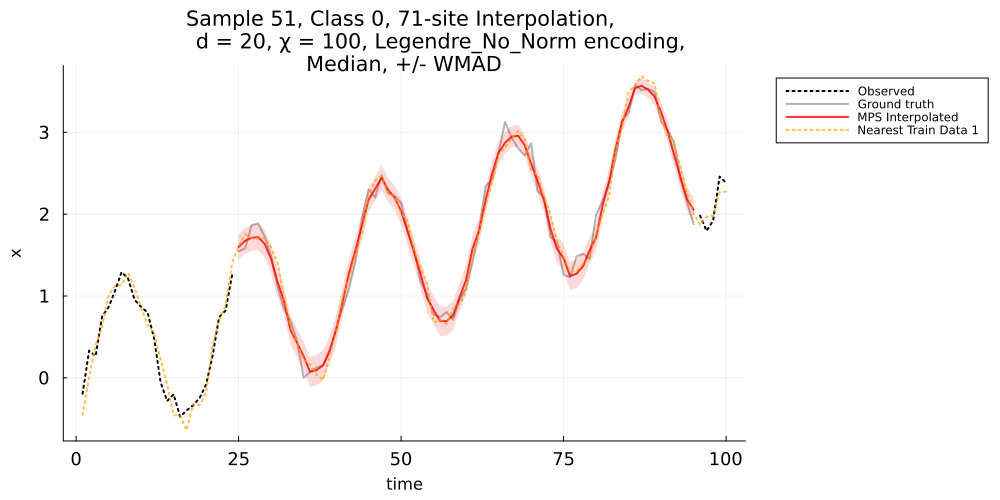

In [87]:
interp_sites = collect(25:95)
class = 0
stats, p1_ns = any_interpolate_median(fc_ns_d1, class, rand(1:size(X_test, 1)), interp_sites; NN_baseline=true, 
    X_train=X_train, y_train=y_train, n_baselines=1, plot_fits=true, wmad=true)
pretty_table(stats; header=["Metric", "Value"], header_crayon= crayon"yellow bold", tf = tf_unicode_rounded);
plot(p1_ns..., xtickfont=font(12), ytickfont=font(12))

╭────────┬──────────╮
│ Metric │    Value │
├────────┼──────────┤
│    MAE │ 0.105819 │
│ NN_MAE │ 0.114631 │
╰────────┴──────────╯


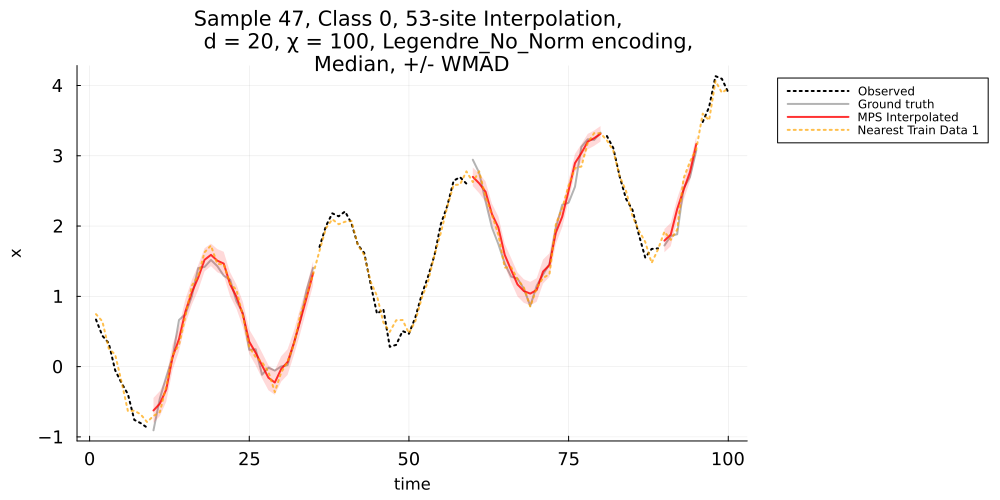

In [94]:
interp_sites = vcat(collect(10:35), collect(60:80), collect(90:95))
class = 0
stats, p1_ns = any_interpolate_median(fc_ns_d1, class, rand(1:size(X_test, 1)), interp_sites; NN_baseline=true, 
    X_train=X_train, y_train=y_train, n_baselines=1, plot_fits=true, wmad=true)
pretty_table(stats; header=["Metric", "Value"], header_crayon= crayon"yellow bold", tf = tf_unicode_rounded);
plot(p1_ns..., xtickfont=font(12), ytickfont=font(12))

In [139]:
svpath_ns = "../../../Data/syntheticV2/complex/mps_saves/dataset1_legendre_ns_d10_chi50.jld2";
dloc =  "../../../Data/syntheticV2/complex/datasets/eta_01_m_var2_tau_20.jld2";

In [140]:
f = jldopen(dloc, "r")
    X_train = read(f, "X_train")
    y_train = read(f, "y_train")
    X_test = read(f, "X_test")
    y_test = read(f, "y_test")
close(f)

In [141]:
f = jldopen(svpath_ns, "r")
    mps_ns = read(f, "mps")
    opts_ns = read(f, "opts")
close(f)
opts_ns, _... = safe_options(opts_ns, nothing, nothing)

fc_ns_d1_2 = load_forecasting_info_variables(mps_ns, X_train, y_train, X_test, y_test, opts_ns);

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 300 training samples and 200 testing samples.
 - 1 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 10, chi_max = 50

 Created 1 forecastable struct(s) containing class-wise mps and test samples.


╭────────┬───────────╮
│ Metric │     Value │
├────────┼───────────┤
│    MAE │ 0.0846967 │
│ NN_MAE │  0.115106 │
╰────────┴───────────╯


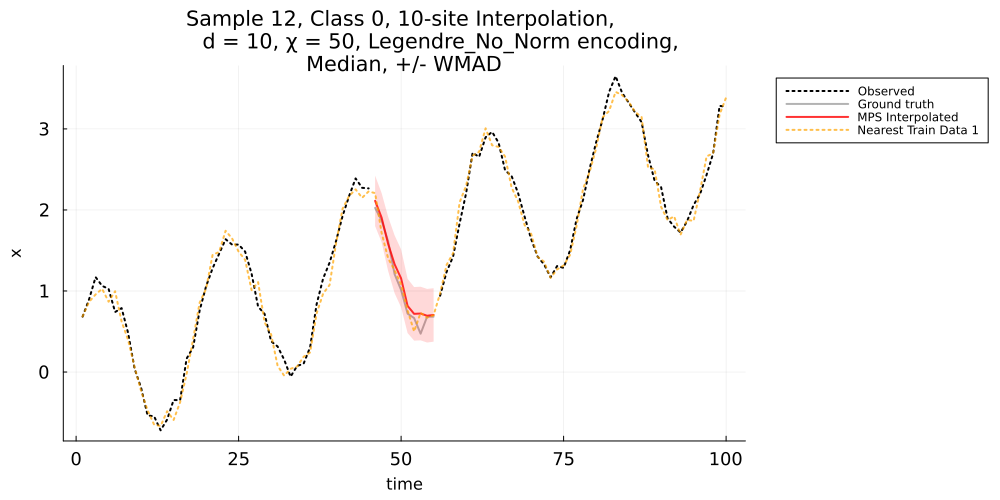

In [143]:
interp_sites = collect(46:55)
class = 0
stats, p1_ns = any_interpolate_median(fc_ns_d1_2, class, 12, interp_sites; NN_baseline=true, 
    X_train=X_train, y_train=y_train, n_baselines=1, plot_fits=true, wmad=true)
pretty_table(stats; header=["Metric", "Value"], header_crayon= crayon"yellow bold", tf = tf_unicode_rounded);
plot(p1_ns..., xtickfont=font(12), ytickfont=font(12))

In [145]:
windows = [(i, j) for (i, j) in zip(6:2:95, 95:-2:6) if j >= i];
nn_mean_mae_per_window_d1_2 = Vector{Float64}(undef, length(windows))
nn_std_mae_per_window_d1_2 = Vector{Float64}(undef, length(windows))
mps_mean_mae_per_window_d1_2 = Vector{Float64}(undef, length(windows))
mps_std_mae_per_window_d1_2 = Vector{Float64}(undef, length(windows))
for (iw, w) in enumerate(windows)
    println("Evaluating window: $w")
    lower, upper = w
    num_samps = size(X_test, 1)
    nn_maes = Vector{Float64}(undef, num_samps)
    mps_maes = Vector{Float64}(undef, num_samps)
    interp_sites = collect(lower:upper)
    for i=1:num_samps
        stats, p1_ns = any_interpolate_median(fc_ns_d1_2, 0, i, interp_sites; NN_baseline=true, 
            X_train=X_train, y_train=y_train, n_baselines=1, plot_fits=false)
        nn_maes[i] = stats[:NN_MAE]
        mps_maes[i] = stats[:MAE]
    end
    # take the mean and std
    mps_mean, mps_std = mean(mps_maes), std(mps_maes)
    nn_mean, nn_std = mean(nn_maes), std(nn_maes)

    nn_mean_mae_per_window_d1_2[iw] = nn_mean
    nn_std_mae_per_window_d1_2[iw] = nn_std
    mps_mean_mae_per_window_d1_2[iw] = mps_mean
    mps_std_mae_per_window_d1_2[iw] = mps_std

    # print stats
    println("Window: $w | MPS mean: $mps_mean MPS std: $mps_std | 1NN mean: $nn_mean | 1NN std: $nn_std")
end

Evaluating window: (6, 95)
Window: (6, 95) | MPS mean: 0.11047280924654837 MPS std: 0.019095474151521085 | 1NN mean: 0.1251675032660689 | 1NN std: 0.01907966260972842
Evaluating window: (8, 93)
Window: (8, 93) | MPS mean: 0.10923893198882581 MPS std: 0.017953848316321845 | 1NN mean: 0.12208341477641654 | 1NN std: 0.015725191285064617
Evaluating window: (10, 91)
Window: (10, 91) | MPS mean: 0.10821516891124668 MPS std: 0.01597652444526378 | 1NN mean: 0.12068433413951497 | 1NN std: 0.013865051552638846
Evaluating window: (12, 89)
Window: (12, 89) | MPS mean: 0.10720342938407659 MPS std: 0.015672918646684124 | 1NN mean: 0.12080491019551368 | 1NN std: 0.014888450320425723
Evaluating window: (14, 87)
Window: (14, 87) | MPS mean: 0.10688562576469357 MPS std: 0.016090732538541753 | 1NN mean: 0.11918813365548822 | 1NN std: 0.01447361918620382
Evaluating window: (16, 85)
Window: (16, 85) | MPS mean: 0.10637030974656515 MPS std: 0.01647358937473995 | 1NN mean: 0.11904088202960737 | 1NN std: 0.01

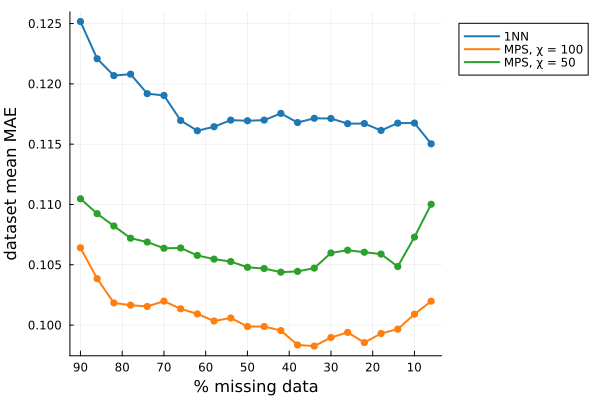

In [146]:
plot(window_sizes[1:end-1], nn_mean_mae_per_window_d1[1:end-1], label="1NN", 
    legend=:outertopright, xlabel="% missing data", ylabel="dataset mean MAE", xticks=collect(90:-10:2),
    c=cpal[1], lw=2)
scatter!(window_sizes[1:end-1], nn_mean_mae_per_window_d1[1:end-1], c=cpal[1], markerstrokewidth=0, label="")
plot!(window_sizes[1:end-1], mps_mean_mae_per_window_d1[1:end-1], label="MPS, χ = 100", c=cpal[2], lw=2)
scatter!(window_sizes[1:end-1], mps_mean_mae_per_window_d1[1:end-1], c=cpal[2], markerstrokewidth=0, label="")
plot!(window_sizes[1:end-1], mps_mean_mae_per_window_d1_2[1:end-1], label="MPS, χ = 50", c=cpal[3], lw=2)
scatter!(window_sizes[1:end-1], mps_mean_mae_per_window_d1_2[1:end-1], c=cpal[3], markerstrokewidth=0, label="")
xflip!(true)

In [147]:
svpath_ns = "../../../Data/syntheticV2/complex/mps_saves/dataset1_legendre_ns_d20_chi50.jld2";
dloc =  "../../../Data/syntheticV2/complex/datasets/eta_01_m_var2_tau_20.jld2";

In [148]:
f = jldopen(svpath_ns, "r")
    mps_ns = read(f, "mps")
    opts_ns = read(f, "opts")
close(f)
opts_ns, _... = safe_options(opts_ns, nothing, nothing)

fc_ns_d1_3 = load_forecasting_info_variables(mps_ns, X_train, y_train, X_test, y_test, opts_ns);

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 300 training samples and 200 testing samples.
 - 1 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 50

 Created 1 forecastable struct(s) containing class-wise mps and test samples.


╭────────┬───────────╮
│ Metric │     Value │
├────────┼───────────┤
│    MAE │ 0.0915305 │
│ NN_MAE │  0.115106 │
╰────────┴───────────╯


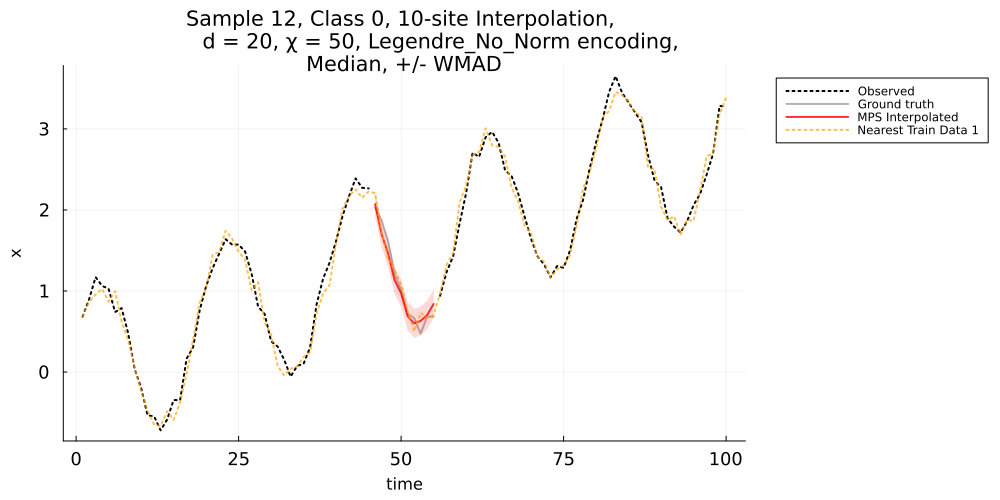

In [149]:
interp_sites = collect(46:55)
class = 0
stats, p1_ns = any_interpolate_median(fc_ns_d1_3, class, 12, interp_sites; NN_baseline=true, 
    X_train=X_train, y_train=y_train, n_baselines=1, plot_fits=true, wmad=true)
pretty_table(stats; header=["Metric", "Value"], header_crayon= crayon"yellow bold", tf = tf_unicode_rounded);
plot(p1_ns..., xtickfont=font(12), ytickfont=font(12))

In [150]:
windows = [(i, j) for (i, j) in zip(6:2:95, 95:-2:6) if j >= i];
nn_mean_mae_per_window_d1_3 = Vector{Float64}(undef, length(windows))
nn_std_mae_per_window_d1_3 = Vector{Float64}(undef, length(windows))
mps_mean_mae_per_window_d1_3 = Vector{Float64}(undef, length(windows))
mps_std_mae_per_window_d1_3 = Vector{Float64}(undef, length(windows))
for (iw, w) in enumerate(windows)
    println("Evaluating window: $w")
    lower, upper = w
    num_samps = size(X_test, 1)
    nn_maes = Vector{Float64}(undef, num_samps)
    mps_maes = Vector{Float64}(undef, num_samps)
    interp_sites = collect(lower:upper)
    for i=1:num_samps
        stats, p1_ns = any_interpolate_median(fc_ns_d1_3, 0, i, interp_sites; NN_baseline=true, 
            X_train=X_train, y_train=y_train, n_baselines=1, plot_fits=false)
        nn_maes[i] = stats[:NN_MAE]
        mps_maes[i] = stats[:MAE]
    end
    # take the mean and std
    mps_mean, mps_std = mean(mps_maes), std(mps_maes)
    nn_mean, nn_std = mean(nn_maes), std(nn_maes)

    nn_mean_mae_per_window_d1_3[iw] = nn_mean
    nn_std_mae_per_window_d1_3[iw] = nn_std
    mps_mean_mae_per_window_d1_3[iw] = mps_mean
    mps_std_mae_per_window_d1_3[iw] = mps_std

    # print stats
    println("Window: $w | MPS mean: $mps_mean MPS std: $mps_std | 1NN mean: $nn_mean | 1NN std: $nn_std")
end

Evaluating window: (6, 95)
Window: (6, 95) | MPS mean: 0.11096883205488456 MPS std: 0.02784995480800851 | 1NN mean: 0.1251675032660689 | 1NN std: 0.01907966260972842
Evaluating window: (8, 93)
Window: (8, 93) | MPS mean: 0.10966157694332722 MPS std: 0.026531558175077265 | 1NN mean: 0.12208341477641654 | 1NN std: 0.015725191285064617
Evaluating window: (10, 91)
Window: (10, 91) | MPS mean: 0.10727618257878556 MPS std: 0.022332566782368325 | 1NN mean: 0.12068433413951497 | 1NN std: 0.013865051552638846
Evaluating window: (12, 89)
Window: (12, 89) | MPS mean: 0.10809416737143081 MPS std: 0.024145672434157654 | 1NN mean: 0.12080491019551368 | 1NN std: 0.014888450320425723
Evaluating window: (14, 87)
Window: (14, 87) | MPS mean: 0.10792734010640662 MPS std: 0.025521579732621067 | 1NN mean: 0.11918813365548822 | 1NN std: 0.01447361918620382
Evaluating window: (16, 85)
Window: (16, 85) | MPS mean: 0.10726852865617507 MPS std: 0.024140151729459224 | 1NN mean: 0.11904088202960737 | 1NN std: 0.0

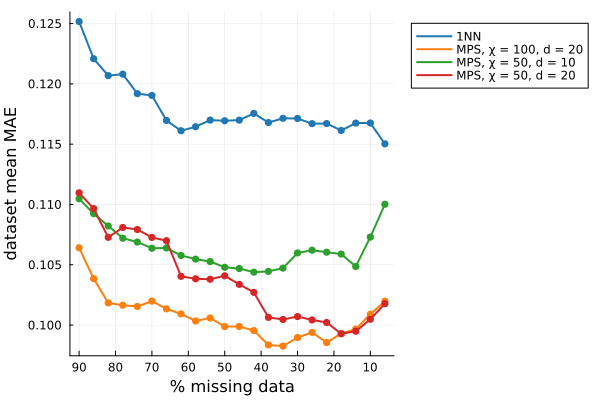

In [152]:
plot(window_sizes[1:end-1], nn_mean_mae_per_window_d1[1:end-1], label="1NN", 
    legend=:outertopright, xlabel="% missing data", ylabel="dataset mean MAE", xticks=collect(90:-10:2),
    c=cpal[1], lw=2)
scatter!(window_sizes[1:end-1], nn_mean_mae_per_window_d1[1:end-1], c=cpal[1], markerstrokewidth=0, label="")
plot!(window_sizes[1:end-1], mps_mean_mae_per_window_d1[1:end-1], label="MPS, χ = 100, d = 20", c=cpal[2], lw=2)
scatter!(window_sizes[1:end-1], mps_mean_mae_per_window_d1[1:end-1], c=cpal[2], markerstrokewidth=0, label="")
plot!(window_sizes[1:end-1], mps_mean_mae_per_window_d1_2[1:end-1], label="MPS, χ = 50, d = 10", c=cpal[3], lw=2)
scatter!(window_sizes[1:end-1], mps_mean_mae_per_window_d1_2[1:end-1], c=cpal[3], markerstrokewidth=0, label="")
plot!(window_sizes[1:end-1], mps_mean_mae_per_window_d1_3[1:end-1], label="MPS, χ = 50, d = 20", c=cpal[4], lw=2)
scatter!(window_sizes[1:end-1], mps_mean_mae_per_window_d1_3[1:end-1], c=cpal[4], markerstrokewidth=0, label="")
xflip!(true)

----

# Dataset 2

In [154]:
function GenerateDifficultTrendyDataset2(T::Int, num_train::Int, num_test::Int; seed=42)
    """Generate a dataset of simple trendy sines, also return stats on the distribution
    over the varying paramters"""
    Random.seed!(seed)
    num_instances = num_train + num_test
    dataset = Matrix{Float64}(undef, num_instances, T)
    phis = Vector{Float64}(undef, num_instances)
    taus = Vector{Float64}(undef, num_instances)
    for i in 1:num_instances
        phi = rand(Uniform(0, 2π)) # randomise the phase offset by sampling its value from a uniform distribution
        tau = rand([20.0, 40.0])
        phis[i] = phi
        taus[i] = tau
        dataset[i, :] = GenerateTrendySine(; phi=phi, tau=tau)
    end

    # now split into test and train by taking random subsets of the joint dataset
    train_idxs = sample(collect(1:num_instances), num_train, replace=false)
    train_phis = phis[train_idxs]
    train_taus = taus[train_idxs]
    test_idxs = setdiff(collect(1:num_instances), train_idxs)
    test_phis = phis[test_idxs]
    test_taus = taus[test_idxs]

    X_train = dataset[train_idxs, :]
    y_train = Int.(zeros(num_train))

    X_test = dataset[test_idxs, :]
    y_test = Int.(zeros(num_test))

    # keep track of the distribution of phi across test and train
    stats = Dict(
        :train_phis => train_phis,
        :test_phis => test_phis,
        :train_taus => train_taus,
        :test_taus => test_taus

    )

    return X_train, y_train, X_test, y_test, stats

end

GenerateDifficultTrendyDataset2 (generic function with 1 method)

In [190]:
X_train, y_train, X_test, y_test, stats = GenerateDifficultTrendyDataset2(100, 300, 400; seed=0);

In [191]:
# jldopen("/Users/joshua/Desktop/QuantumInspiredML/Data/syntheticV2/complex/datasets/eta_01_m_3_tau_var2.jld2", "w") do f
#     f["X_train"] = X_train
#     f["y_train"] = y_train
#     f["X_test"] = X_test
#     f["y_test"] = y_test
#     f["stats"] = stats
# end

Dict{Symbol, Vector{Float64}} with 4 entries:
  :train_taus => [40.0, 20.0, 20.0, 20.0, 40.0, 40.0, 20.0, 40.0, 40.0, 40.0  ……
  :test_taus  => [20.0, 20.0, 40.0, 40.0, 40.0, 20.0, 40.0, 20.0, 40.0, 40.0  ……
  :train_phis => [3.78788, 5.64048, 5.95711, 3.81348, 2.14079, 1.75196, 0.03792…
  :test_phis  => [0.528053, 4.32605, 1.36907, 4.5573, 6.06644, 1.5349, 1.46096,…

In [158]:
svpath_ns = "../../../Data/syntheticV2/complex/mps_saves/dataset2_legendre_ns_d20_chi100.jld2";
dloc =  "../../../Data/syntheticV2/complex/datasets/eta_01_m_3_tau_var2.jld2";
f = jldopen(dloc, "r")
    X_train = read(f, "X_train")
    y_train = read(f, "y_train")
    X_test = read(f, "X_test")
    y_test = read(f, "y_test")
close(f)
f = jldopen(svpath_ns, "r")
    mps_ns = read(f, "mps")
    opts_ns = read(f, "opts")
close(f)
opts_ns, _... = safe_options(opts_ns, nothing, nothing)

fc_ns_d2 = load_forecasting_info_variables(mps_ns, X_train, y_train, X_test, y_test, opts_ns);

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 300 training samples and 200 testing samples.
 - 1 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 20, chi_max = 100

 Created 1 forecastable struct(s) containing class-wise mps and test samples.


In [182]:
windows = [(i, j) for (i, j) in zip(6:2:95, 95:-2:6) if j >= i];
nn_mean_mae_per_window_d2 = Vector{Float64}(undef, length(windows))
nn_median_mae_per_window_d2 = Vector{Float64}(undef, length(windows))
nn_std_mae_per_window_d2 = Vector{Float64}(undef, length(windows))
mps_mean_mae_per_window_d2 = Vector{Float64}(undef, length(windows))
mps_std_mae_per_window_d2 = Vector{Float64}(undef, length(windows))
mps_median_mae_per_window_d2 = Vector{Float64}(undef, length(windows))
for (iw, w) in enumerate(windows)
    println("Evaluating window: $w")
    lower, upper = w
    num_samps = size(X_test, 1)
    nn_maes = Vector{Float64}(undef, num_samps)
    mps_maes = Vector{Float64}(undef, num_samps)
    interp_sites = collect(lower:upper)
    for i=1:num_samps
        stats, p1_ns = any_interpolate_median(fc_ns_d2, 0, i, interp_sites; NN_baseline=true, 
            X_train=X_train, y_train=y_train, n_baselines=1, plot_fits=false)
        nn_maes[i] = stats[:NN_MAE]
        mps_maes[i] = stats[:MAE]
    end
    # take the mean and std
    mps_mean, mps_std = mean(mps_maes), std(mps_maes)
    nn_mean, nn_std = mean(nn_maes), std(nn_maes)
    nn_median, mps_median = median(nn_maes), median(mps_maes)

    nn_mean_mae_per_window_d2[iw] = nn_mean
    nn_std_mae_per_window_d2[iw] = nn_std
    nn_median_mae_per_window_d2[iw] = nn_median
    mps_mean_mae_per_window_d2[iw] = mps_mean
    mps_std_mae_per_window_d2[iw] = mps_std
    mps_median_mae_per_window_d2[iw] = mps_median

    # print stats
    println("Window: $w | MPS mean: $mps_mean MPS median: $mps_median MPS std: $mps_std | 1NN mean: $nn_mean | 1NN median: $nn_median 1NN std: $nn_std")
end

Evaluating window: (6, 95)
Window: (6, 95) | MPS mean: 0.12215719370344942 MPS median: 0.10457296756242404 MPS std: 0.08686034254313374 | 1NN mean: 0.12689328852845633 | 1NN median: 0.12181513736489957 1NN std: 0.022134876949194433
Evaluating window: (8, 93)
Window: (8, 93) | MPS mean: 0.11730759522107817 MPS median: 0.1023640816831386 MPS std: 0.08093370004945362 | 1NN mean: 0.12207817554249342 | 1NN median: 0.12114908881226037 1NN std: 0.01374273136268128
Evaluating window: (10, 91)
Window: (10, 91) | MPS mean: 0.1088046974342182 MPS median: 0.1029429841766977 MPS std: 0.02171469390486819 | 1NN mean: 0.1226661090480415 | 1NN median: 0.12053587086069001 1NN std: 0.015921158680637273
Evaluating window: (12, 89)
Window: (12, 89) | MPS mean: 0.10886148402318409 MPS median: 0.10429907300888039 MPS std: 0.02153797087073393 | 1NN mean: 0.120650253848448 | 1NN median: 0.11845489507296873 1NN std: 0.01520505284630935
Evaluating window: (14, 87)
Window: (14, 87) | MPS mean: 0.10896676256020038

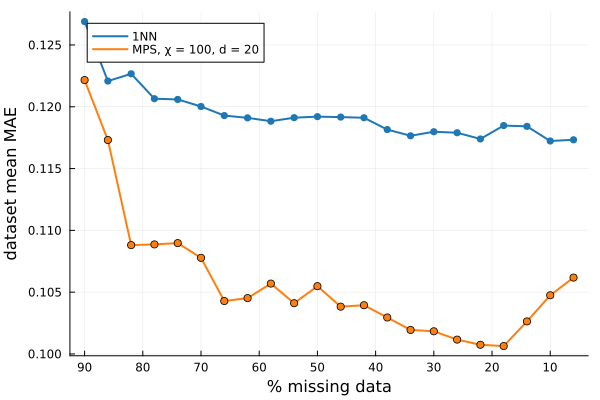

In [181]:
plot(window_sizes[1:end-1], nn_mean_mae_per_window_d2[1:end-1], label="1NN", xlabel="% missing data", ylabel="dataset mean MAE", xticks=collect(90:-10:2),
    c=cpal[1], lw=2)
scatter!(window_sizes[1:end-1], nn_mean_mae_per_window_d2[1:end-1], c=cpal[1], markerstrokewidth=0, label="")
plot!(window_sizes[1:end-1], mps_mean_mae_per_window_d2[1:end-1], label="MPS, χ = 100, d = 20", c=cpal[2], lw=2)
scatter!(window_sizes[1:end-1], mps_mean_mae_per_window_d2[1:end-1], label="", c=cpal[2])
xflip!(true)

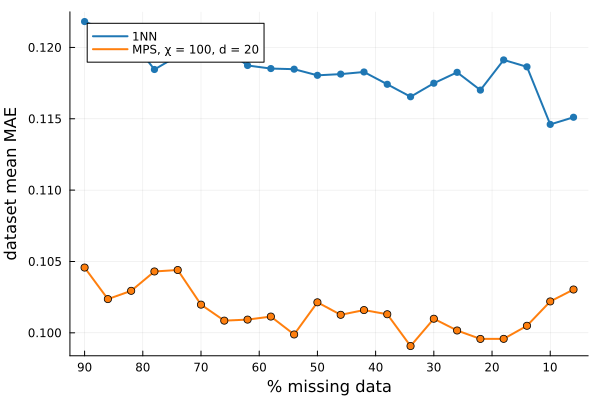

In [183]:
plot(window_sizes[1:end-1], nn_median_mae_per_window_d2[1:end-1], label="1NN", xlabel="% missing data", ylabel="dataset mean MAE", xticks=collect(90:-10:2),
    c=cpal[1], lw=2)
scatter!(window_sizes[1:end-1], nn_median_mae_per_window_d2[1:end-1], c=cpal[1], markerstrokewidth=0, label="")
plot!(window_sizes[1:end-1], mps_median_mae_per_window_d2[1:end-1], label="MPS, χ = 100, d = 20", c=cpal[2], lw=2)
scatter!(window_sizes[1:end-1], mps_median_mae_per_window_d2[1:end-1], label="", c=cpal[2])
xflip!(true)

╭────────┬───────────╮
│ Metric │     Value │
├────────┼───────────┤
│    MAE │  0.111378 │
│ NN_MAE │ 0.0546008 │
╰────────┴───────────╯


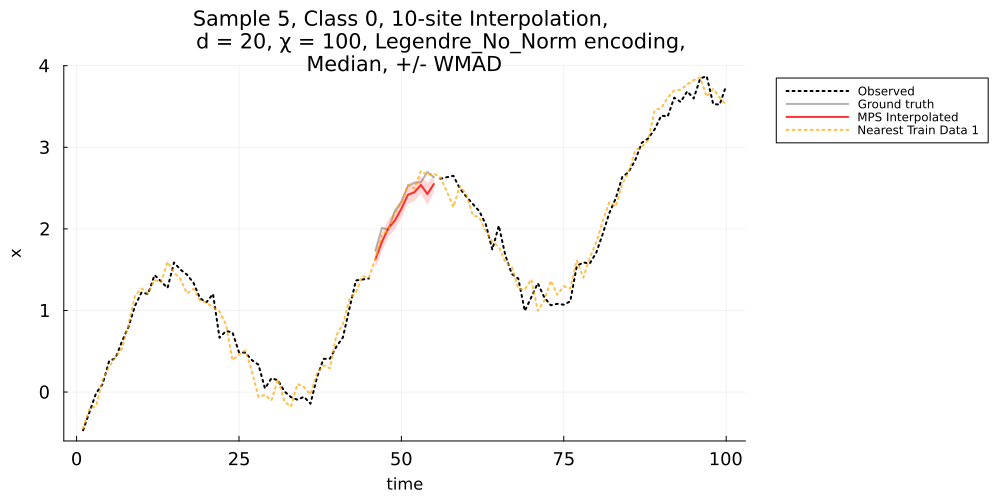

In [188]:
interp_sites = collect(46:55)
class = 0
stats, p1_ns = any_interpolate_median(fc_ns_d2, class, 5, interp_sites; NN_baseline=true, 
    X_train=X_train, y_train=y_train, n_baselines=1, plot_fits=true, wmad=true)
pretty_table(stats; header=["Metric", "Value"], header_crayon= crayon"yellow bold", tf = tf_unicode_rounded);
plot(p1_ns..., xtickfont=font(12), ytickfont=font(12))